In [3]:
from numpy.linalg import svd

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset with correct separator
file_path = "/home/maria/CrimeStats/data/avalik_1(1).csv"
dat = pd.read_csv(file_path, sep='\t', encoding='utf-8')

# Filter for Tallinn
tallinn = dat[dat['ValdLinnNimetus'] == 'Tallinn'].copy()

# Parse date and time
tallinn['ToimKpv'] = pd.to_datetime(tallinn['ToimKpv'], errors='coerce')
tallinn['ToimKell'] = tallinn['ToimKell'].fillna('00:00')
tallinn['ToimKell'] = pd.to_timedelta(tallinn['ToimKell'] + ':00')

# Combine to datetime
tallinn['ToimDatetime'] = tallinn['ToimKpv'] + tallinn['ToimKell']
tallinn = tallinn.dropna(subset=['ToimDatetime'])

# Clean and split crime types
tallinn['SyndmusLiik'] = (
    tallinn['SyndmusLiik']
    .fillna('')
    .astype(str)
    .str.strip()
    .str.upper()
)

# Split by comma and explode to new rows
tallinn_expanded = tallinn.assign(
    SyndmusLiik=tallinn['SyndmusLiik'].str.split(',')
).explode('SyndmusLiik')

# Remove whitespace and invalid empty entries
tallinn_expanded['SyndmusLiik'] = tallinn_expanded['SyndmusLiik'].str.strip()
tallinn_expanded = tallinn_expanded[tallinn_expanded['SyndmusLiik'] != '']

# Set datetime index
tallinn_expanded.set_index('ToimDatetime', inplace=True)

# Group by day and crime type
daily_crime_matrix = (
    tallinn_expanded
    .groupby([pd.Grouper(freq='D'), 'SyndmusLiik'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)
daily_crime_matrix.shape
daily_crime_matrix

SyndmusLiik,AVALIKU_KORRA_RIKKUMINE,ILLEGAALNE_KAUBA_MUUK,JALGRATTA_MOPEEDI_VARGUS,JUHTUM_LOOMAGA,JUHTUM_TULIRELVAGA,KADUNUD_ESE/DOKUMENT,KAUPLEMISE_NOUETE_RIKKUMINE,KEHALINE_VAARKOHTLEMINE,KELMUS,KONFLIKT/OMAVOLI,...,MUU,NARKOJUHTUM,PISIVARGUS,PLAHVATUS,POMMIAHVARDUS_KAHTLUS,ROOVIMINE,TULEKAHJU,VALIMISED,VANDALISM,VARGUS
ToimDatetime,,,,,,,,,,,,,,,,,,,,,
2024-01-01,1,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,4,8
2024-01-02,1,0,0,0,0,0,0,1,0,0,...,0,0,6,0,0,0,0,0,0,6
2024-01-03,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,1,5
2024-01-04,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,0,0,0,1,4
2024-01-05,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-15,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3
2025-05-16,0,0,0,0,0,0,0,0,0,0,...,1,0,3,0,0,0,0,0,0,3
2025-05-18,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,1


In [18]:
X = (daily_crime_matrix.values - daily_crime_matrix.values.mean(axis=0)) / daily_crime_matrix.values.std(axis=0)
U,Sigma,V_trans=svd(X)

In [8]:
print(U.shape)

(505, 505)


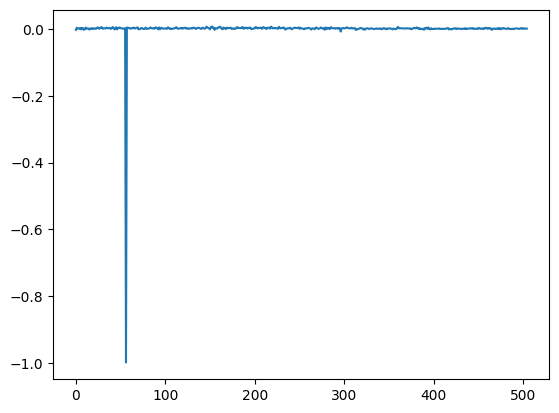

In [20]:
import matplotlib.pyplot as plt

plt.plot(U[:,:1])

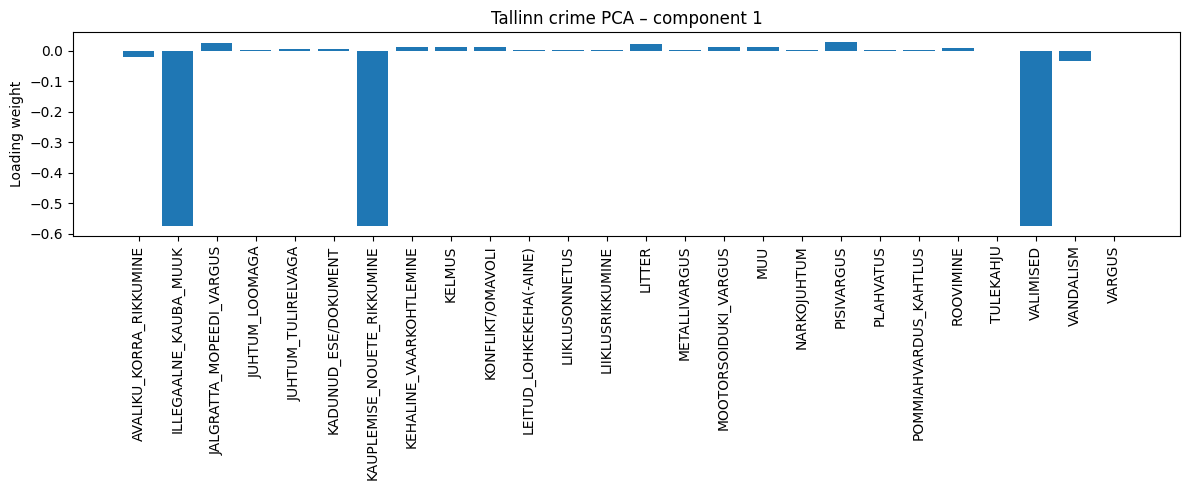

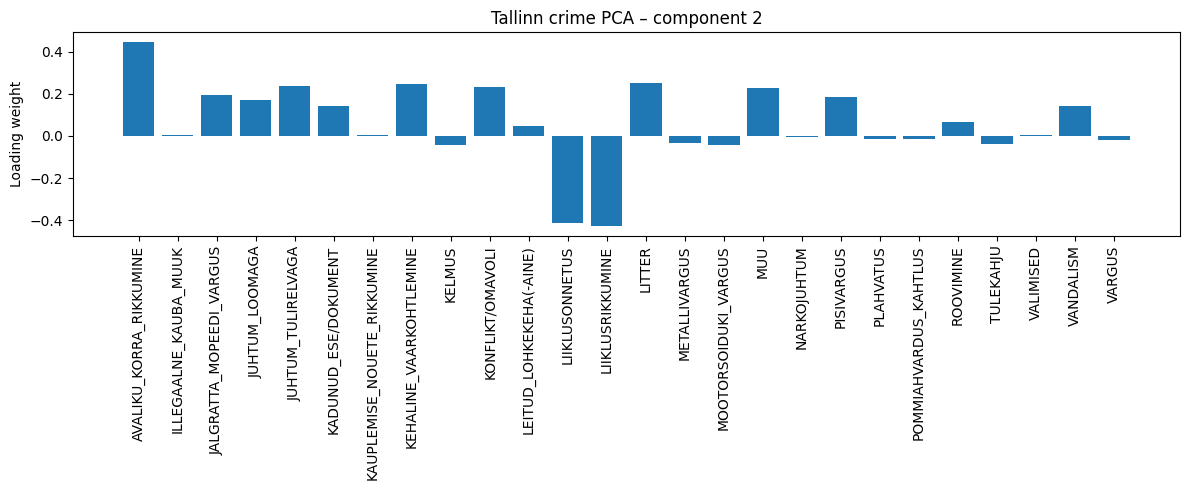

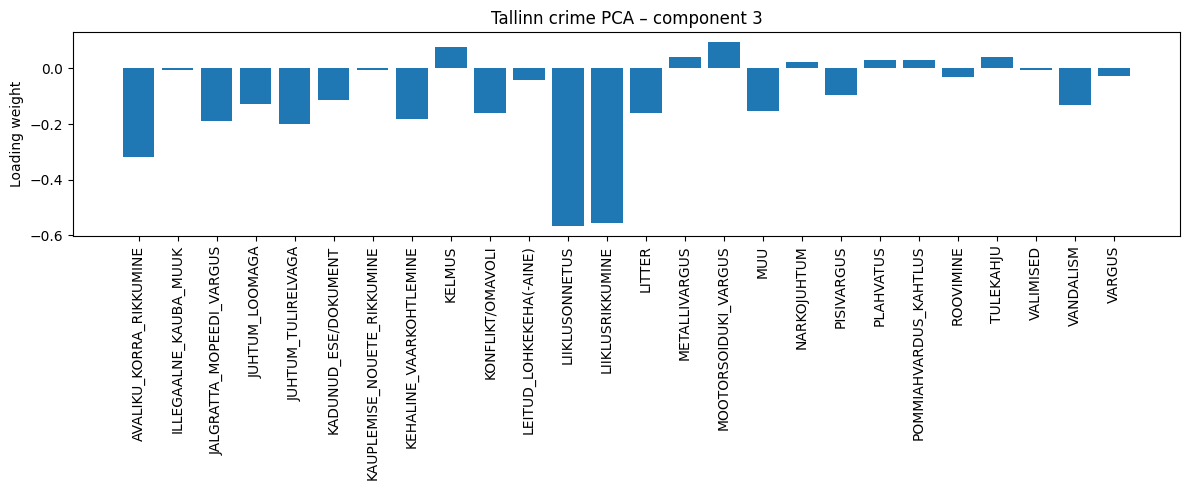

In [26]:
import numpy as np

# ============================================
# CENTER DATA
# ============================================
X = daily_crime_matrix.values
X = (X - X.mean(axis=0)) / X.std(axis=0)


# ============================================
# SVD
# ============================================
U, S, Vt = np.linalg.svd(X, full_matrices=False)
V = Vt.T
crime_names = daily_crime_matrix.columns

# ============================================
# SHOW FIRST 3 PCA COMPONENTS
# ============================================
for k in range(3):
    plt.figure(figsize=(12, 5))
    plt.bar(range(len(crime_names)), V[:, k])
    plt.xticks(range(len(crime_names)), crime_names, rotation=90)
    plt.ylabel("Loading weight")
    plt.title(f"Tallinn crime PCA – component {k+1}")
    plt.tight_layout()
    plt.show()


In [21]:
import numpy as np

u1 = U[:, 0]
outlier_idx = np.argmax(np.abs(u1))

print("Outlier row index:", outlier_idx)
print("Outlier U value:", u1[outlier_idx])
print("Outlier date:", daily_crime_matrix.index[outlier_idx])

print("\nTop crimes on that day:")
print(daily_crime_matrix.iloc[outlier_idx].sort_values(ascending=False).head(10))


Outlier row index: 56
Outlier U value: -0.9982282276267563
Outlier date: 2024-02-26 00:00:00

Top crimes on that day:
SyndmusLiik
VARGUS                         6
PISIVARGUS                     2
VANDALISM                      2
KAUPLEMISE_NOUETE_RIKKUMINE    1
AVALIKU_KORRA_RIKKUMINE        1
ILLEGAALNE_KAUBA_MUUK          1
VALIMISED                      1
JALGRATTA_MOPEEDI_VARGUS       0
JUHTUM_TULIRELVAGA             0
JUHTUM_LOOMAGA                 0
Name: 2024-02-26 00:00:00, dtype: int64


In [22]:
import numpy as np
import pandas as pd

# already have X (z-scored), U,S,Vt from before
V = Vt.T
pc1 = V[:,0]

# outlier day index
u1 = U[:,0]
t = np.argmax(np.abs(u1))

# credit assignment
x_t = X[t]
contrib = x_t * pc1

df = pd.DataFrame({
    "crime": daily_crime_matrix.columns,
    "x_t": x_t,
    "pc1_loading": pc1,
    "contribution": contrib,
    "abs_contribution": np.abs(contrib)
}).sort_values("abs_contribution", ascending=False)

print("Outlier day:", daily_crime_matrix.index[t])
print(df.head(10))


Outlier day: 2024-02-26 00:00:00
                          crime        x_t  pc1_loading  contribution  \
1         ILLEGAALNE_KAUBA_MUUK  22.449944    -0.576068    -12.932684   
6   KAUPLEMISE_NOUETE_RIKKUMINE  22.449944    -0.576068    -12.932684   
23                    VALIMISED  22.449944    -0.576068    -12.932684   
24                    VANDALISM   0.846267    -0.032364     -0.027388   
18                   PISIVARGUS  -0.706023     0.030260     -0.021364   
2      JALGRATTA_MOPEEDI_VARGUS  -0.602290     0.025856     -0.015573   
0       AVALIKU_KORRA_RIKKUMINE   0.701056    -0.021554     -0.015111   
13                       LITTER  -0.479668     0.020903     -0.010027   
16                          MUU  -0.365967     0.013295     -0.004866   
15         MOOTORSOIDUKI_VARGUS  -0.305410     0.013550     -0.004138   

    abs_contribution  
1          12.932684  
6          12.932684  
23         12.932684  
24          0.027388  
18          0.021364  
2           0.015573  
0 

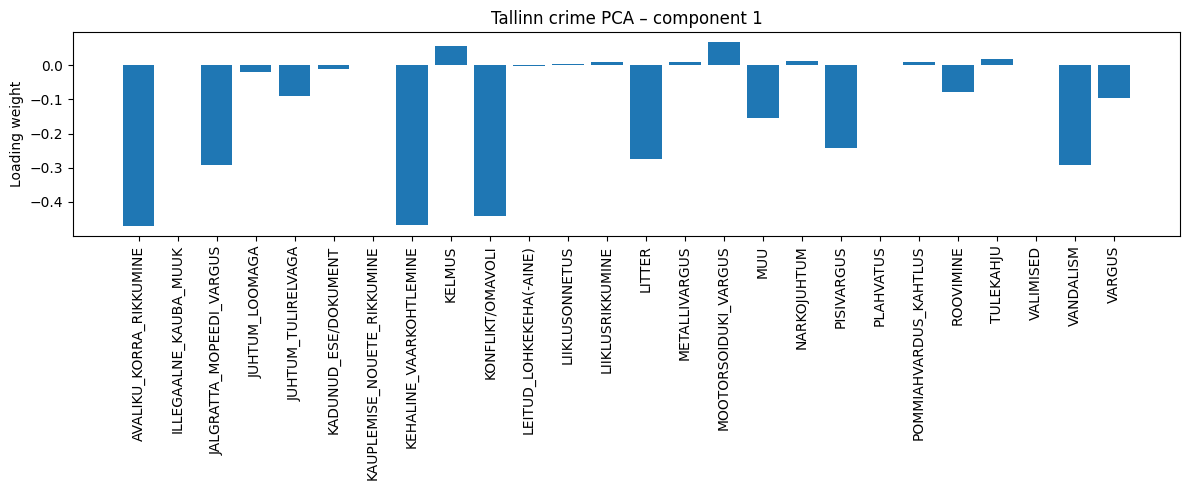

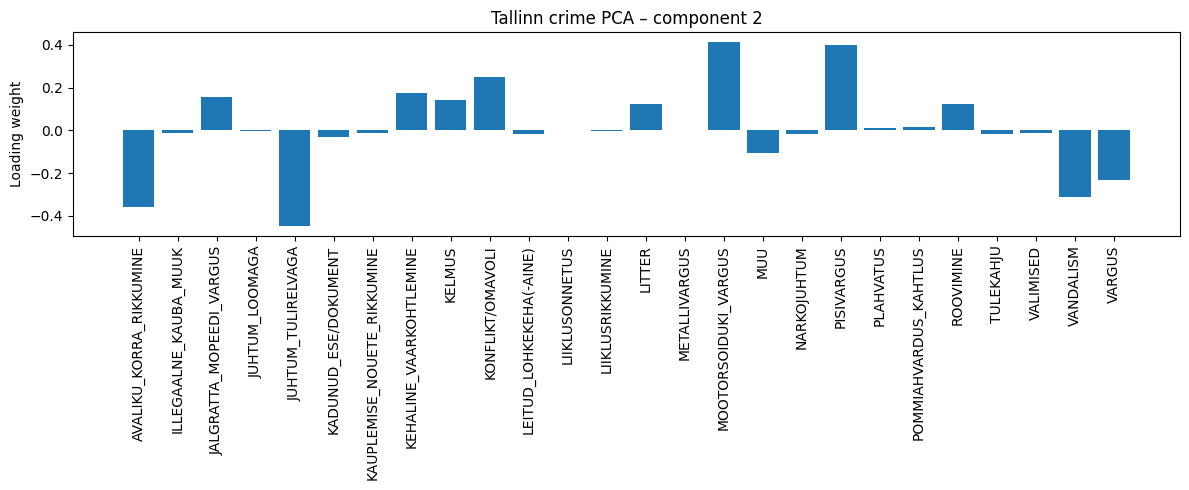

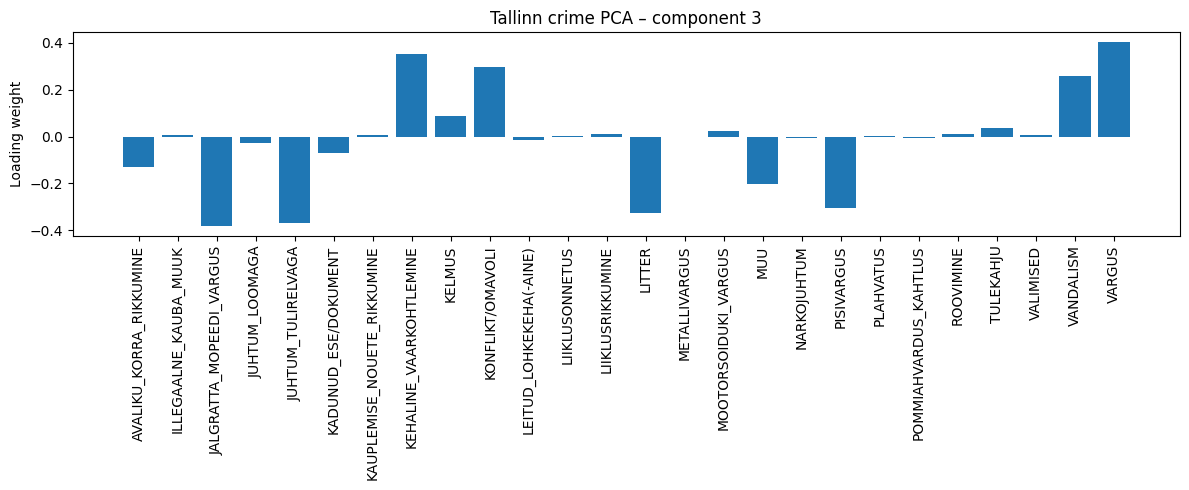

In [29]:
import numpy as np

# ============================================
# CENTER DATA
# ============================================
X = daily_crime_matrix.values
X = np.log1p(daily_crime_matrix.values)
X = (X - X.mean(axis=0)) / X.std(axis=0)
X = np.clip(X, -5, 5)

# ============================================
# SVD
# ============================================
U, S, Vt = np.linalg.svd(X, full_matrices=False)
V = Vt.T
crime_names = daily_crime_matrix.columns

# ============================================
# SHOW FIRST 3 PCA COMPONENTS
# ============================================
for k in range(3):
    plt.figure(figsize=(12, 5))
    plt.bar(range(len(crime_names)), V[:, k])
    plt.xticks(range(len(crime_names)), crime_names, rotation=90)
    plt.ylabel("Loading weight")
    plt.title(f"Tallinn crime PCA – component {k+1}")
    plt.tight_layout()
    plt.show()


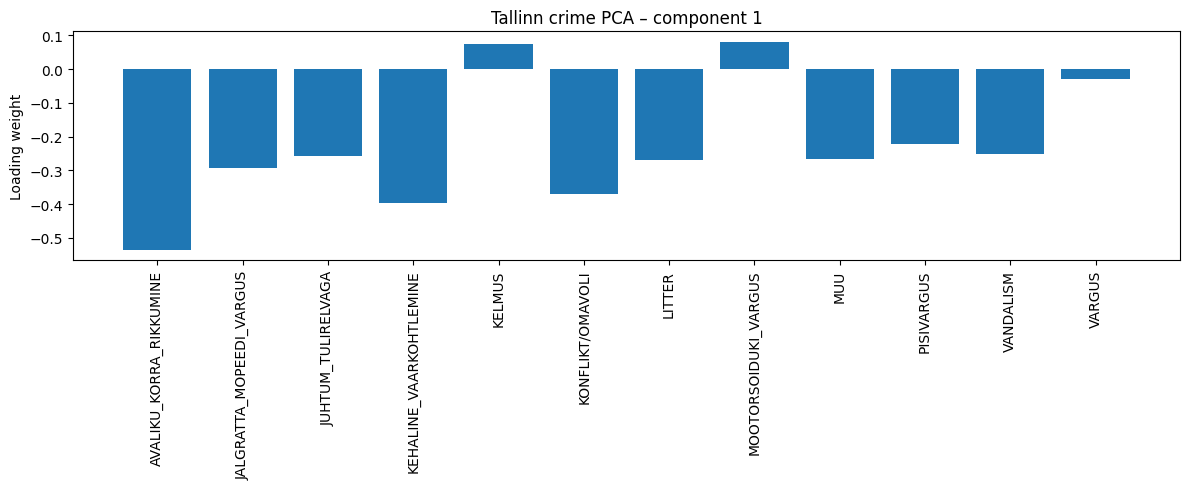

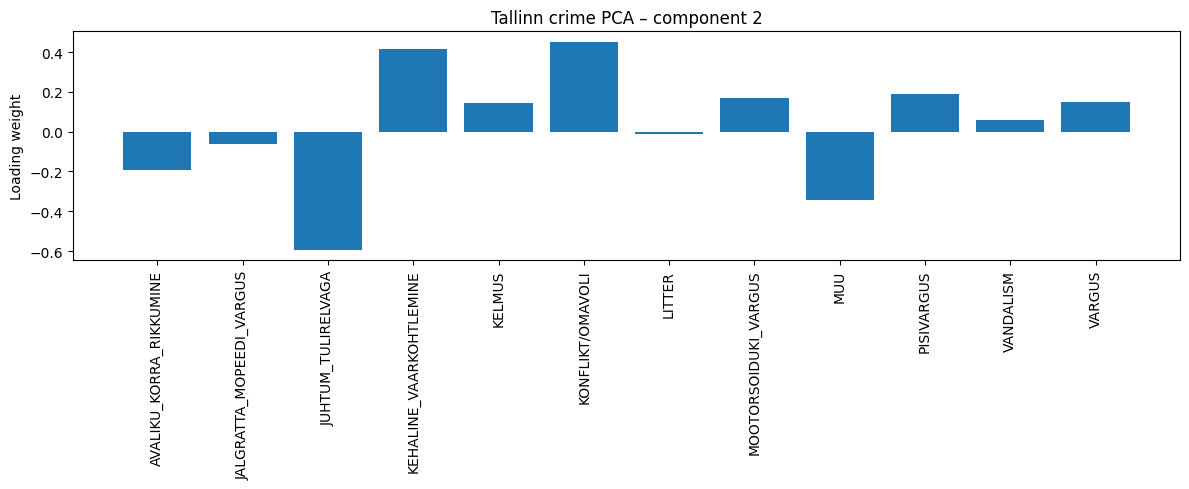

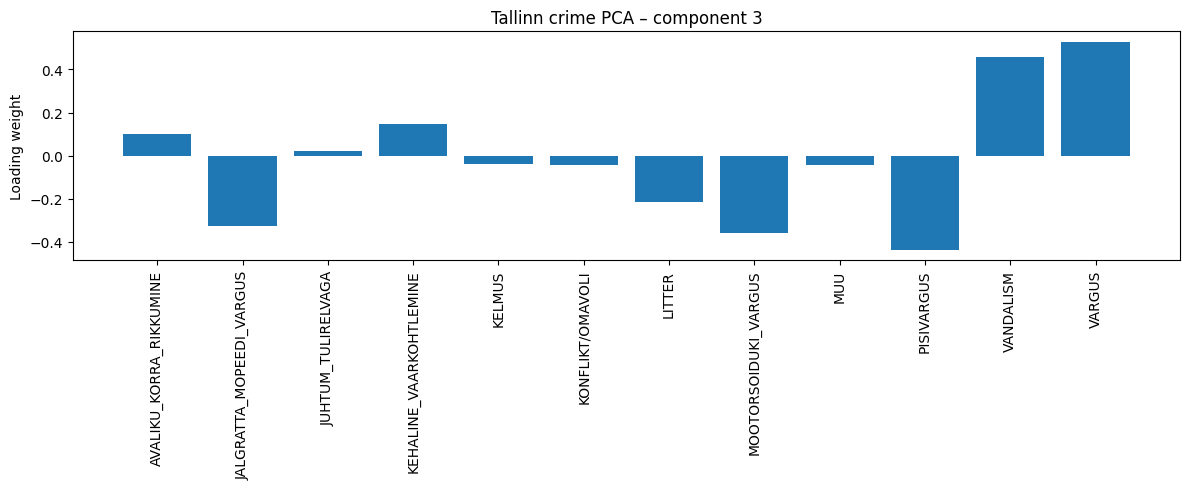

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# FILTER ULTRA-RARE CRIMES
# ============================================
keep = daily_crime_matrix.sum(axis=0) > 20
X_df = daily_crime_matrix.loc[:, keep]
crime_names = X_df.columns

# ============================================
# STABLE NORMALIZATION
# ============================================
X = X_df.values.astype(float)
std = X.std(axis=0)
std[std == 0] = 1.0          # avoid divide-by-zero
X = (X - X.mean(axis=0)) / std

# ============================================
# PCA via SVD
# ============================================
U, S, Vt = np.linalg.svd(X, full_matrices=False)
V = Vt.T

# ============================================
# SHOW FIRST 3 PCA COMPONENTS
# ============================================
for k in range(3):
    plt.figure(figsize=(12, 5))
    plt.bar(range(len(crime_names)), V[:, k])
    plt.xticks(range(len(crime_names)), crime_names, rotation=90)
    plt.ylabel("Loading weight")
    plt.title(f"Tallinn crime PCA – component {k+1}")
    plt.tight_layout()
    plt.show()


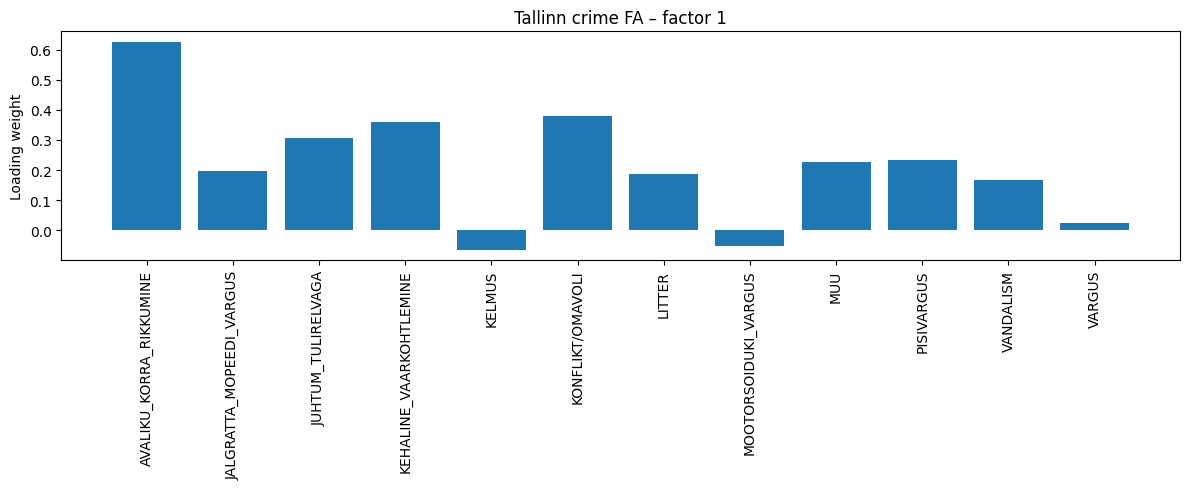

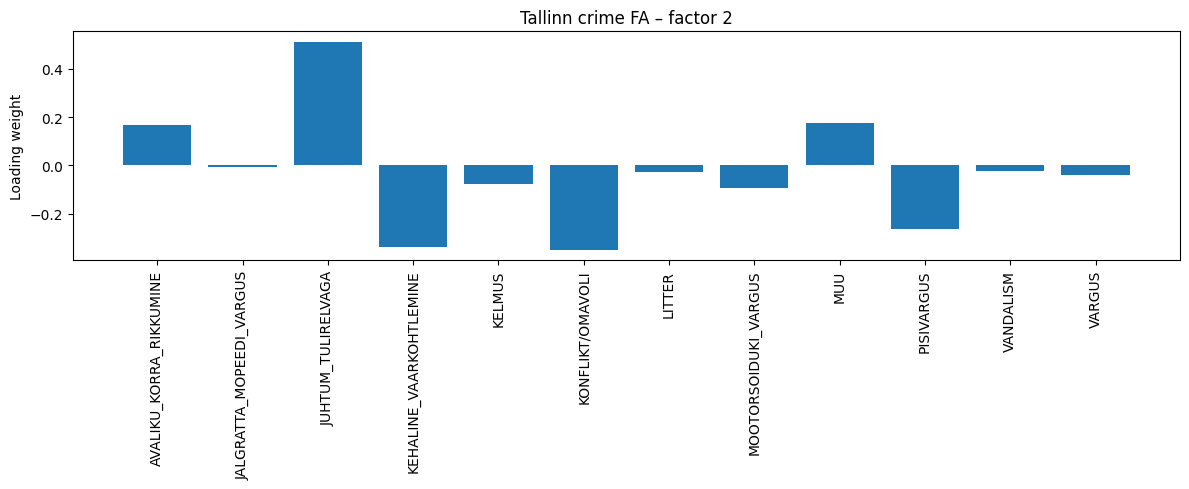

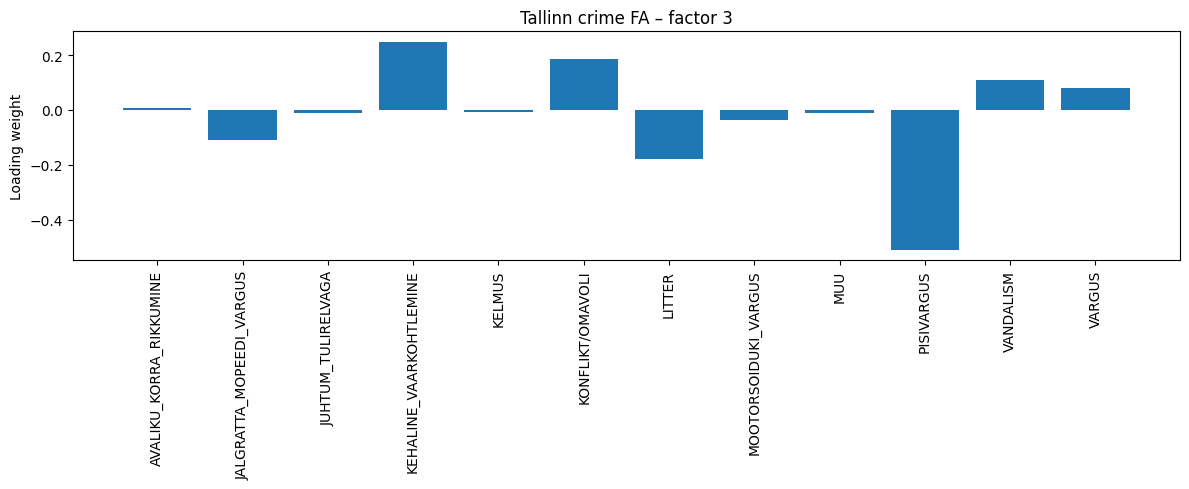

In [34]:
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# FACTOR ANALYSIS
# ============================================
k = 3   # number of latent factors
fa = FactorAnalysis(n_components=k, random_state=0)
fa.fit(X)

Lambda = fa.components_.T    # shape: (n_crimes × k)

# ============================================
# SHOW FACTOR LOADINGS
# ============================================
for j in range(k):
    plt.figure(figsize=(12,5))
    plt.bar(range(len(crime_names)), Lambda[:, j])
    plt.xticks(range(len(crime_names)), crime_names, rotation=90)
    plt.ylabel("Loading weight")
    plt.title(f"Tallinn crime FA – factor {j+1}")
    plt.tight_layout()
    plt.show()


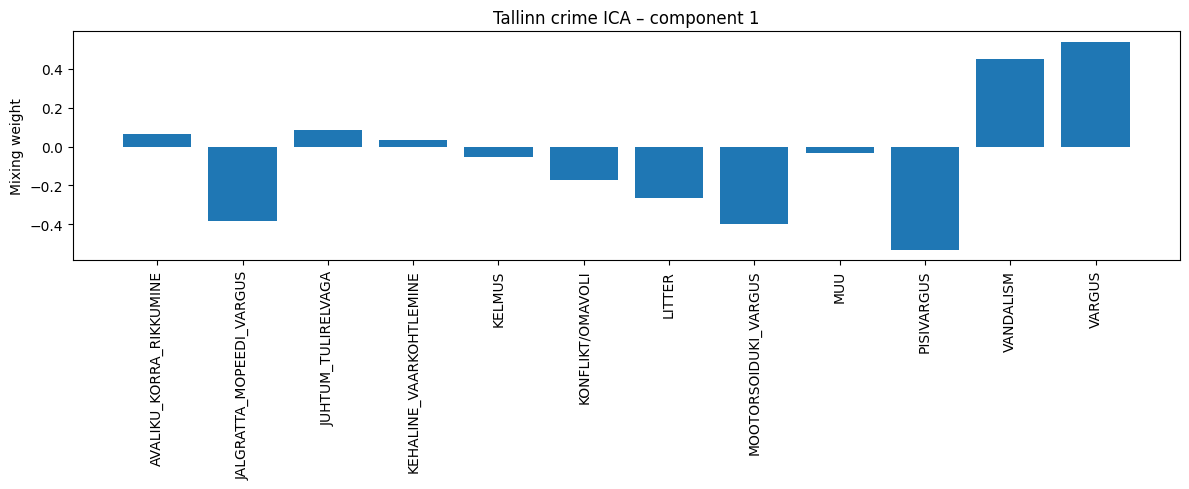

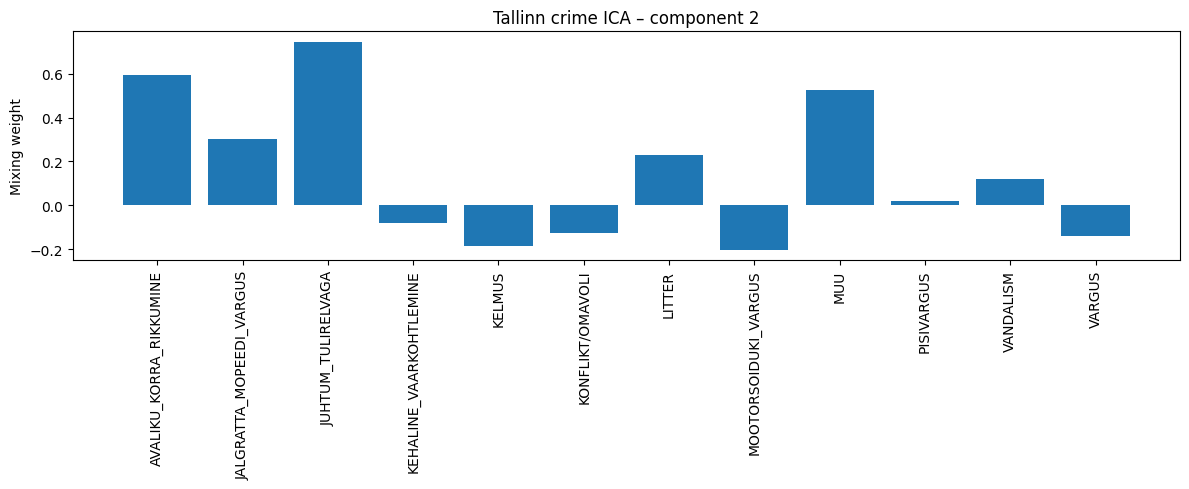

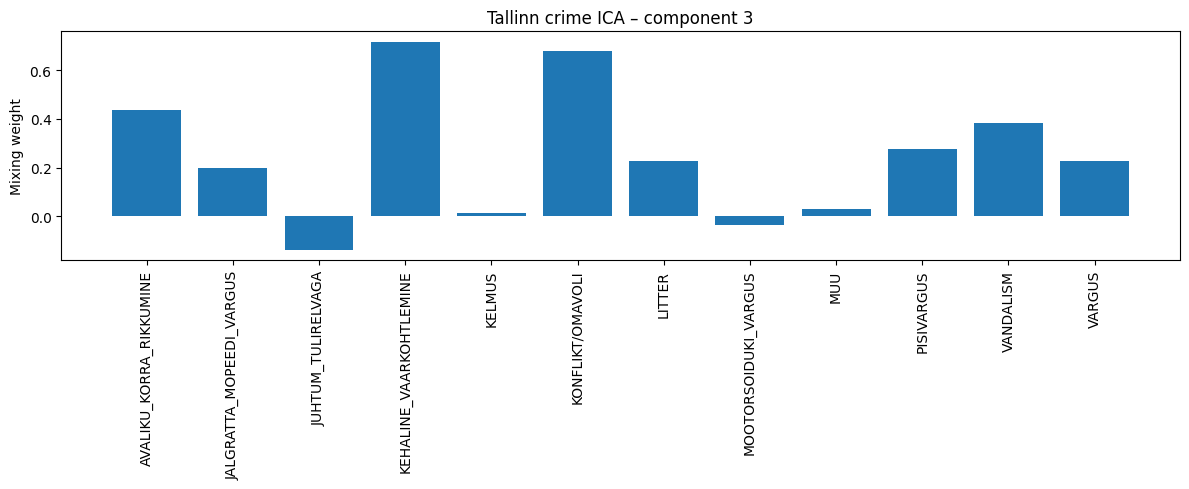

In [35]:
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# ICA
# ============================================
k = 3
ica = FastICA(n_components=k, random_state=0, whiten='unit-variance')
S = ica.fit_transform(X)     # latent time-series (n_days × k)
A = ica.mixing_              # mixing matrix (n_crimes × k)

# ============================================
# SHOW ICA COMPONENTS
# ============================================
for j in range(k):
    plt.figure(figsize=(12,5))
    plt.bar(range(len(crime_names)), A[:, j])
    plt.xticks(range(len(crime_names)), crime_names, rotation=90)
    plt.ylabel("Mixing weight")
    plt.title(f"Tallinn crime ICA – component {j+1}")
    plt.tight_layout()
    plt.show()
